In [40]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [41]:
import openpyxl as op;
brent = op.load_workbook(r'C:\Users\arina.borisova\Desktop\AD\2 семестр\Datasets\brent1.xlsx');
 
sheet = brent.get_sheet_by_name('нефть brent');
from itertools import islice
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = pd.DataFrame(data, index=idx, columns=cols)
df.head(10)

,Value
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59
2019-08-26,58.26
2019-08-25,57.81
2019-08-23,58.94
2019-08-22,60.05
2019-08-21,60.38


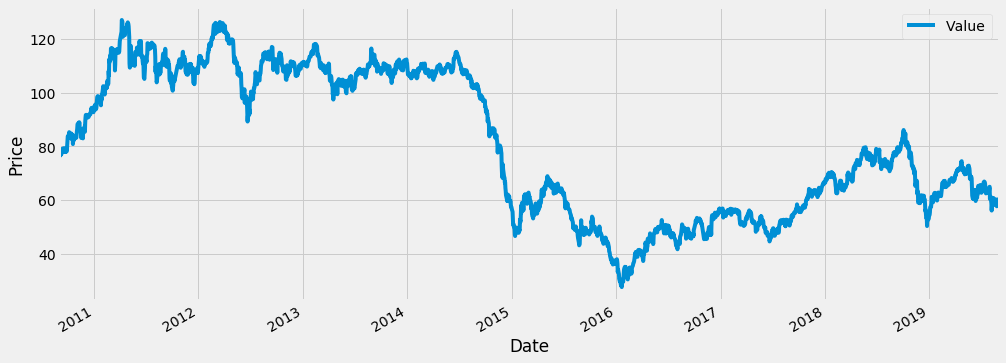

In [42]:
df.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Выберем оптимальные значения параметров для модели временных рядов ARIMA (p, d, q) (P, D, Q).

In [43]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [44]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:31299.262438970753
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:27687.08310351339
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15106.993220788529
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:15046.698515619071
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15113.48094399759
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:15106.859870816304
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:15051.203194769256
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:15036.633243785522
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27641.804272392546
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:24117.370673400936
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:12821.650872220778
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12756.521374207958
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12831.453426521946
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12809.388783159873
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12764.871740324143
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:12755.603878622976
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8695.305118485556
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8663.547752623

SARIMAX (0, 1, 1)x(0, 1, 1, 12) дает самое низкое значение AIC - 515.40702526277. Поэтому мы должны считать это оптимальным вариантом из всех рассмотренных нами моделей. Добавим оптимальные значения параметров в новую модель SARIMAX:

In [17]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4049      0.105      3.868      0.000       0.200       0.610
ma.S.L12      -0.8165      0.168     -4.862      0.000      -1.146      -0.487
sigma2        26.9828      4.822      5.595      0.000      17.531      36.434


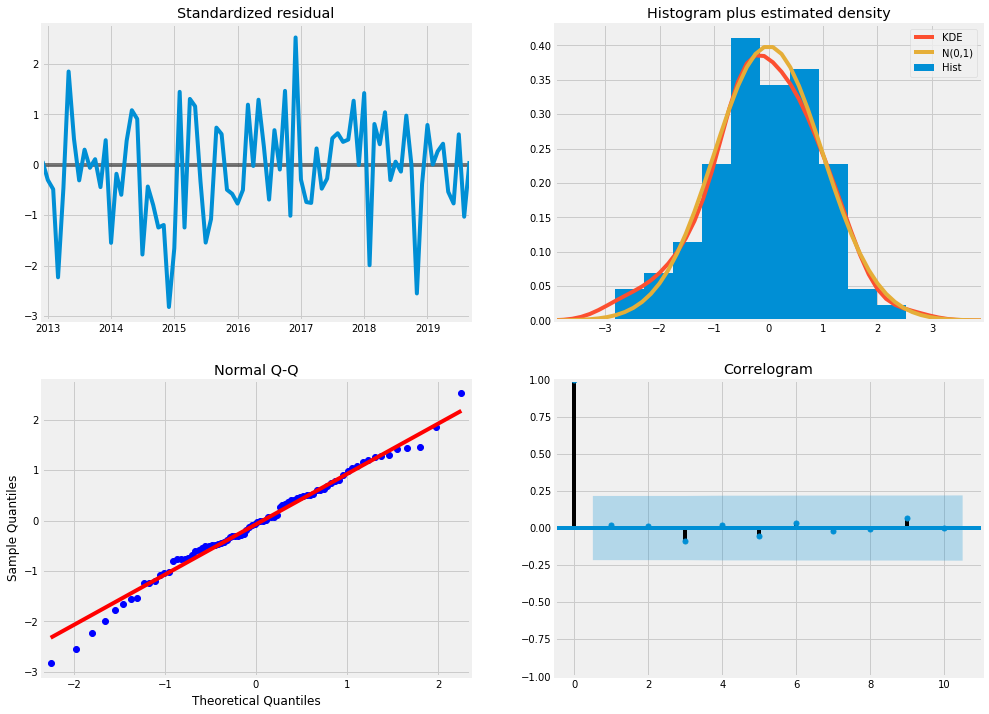

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

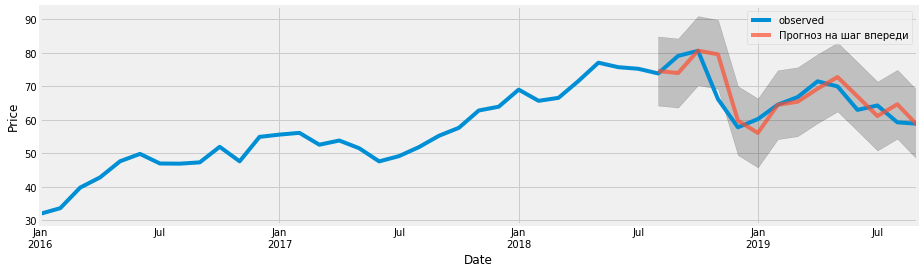

In [38]:
pred = results.get_prediction(start=pd.to_datetime('2018-08-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Прогноз на шаг впереди', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [39]:
df_forecasted = pred.predicted_mean
df_truth = df['2018-08-01':]

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 21.11


In [29]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-08-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

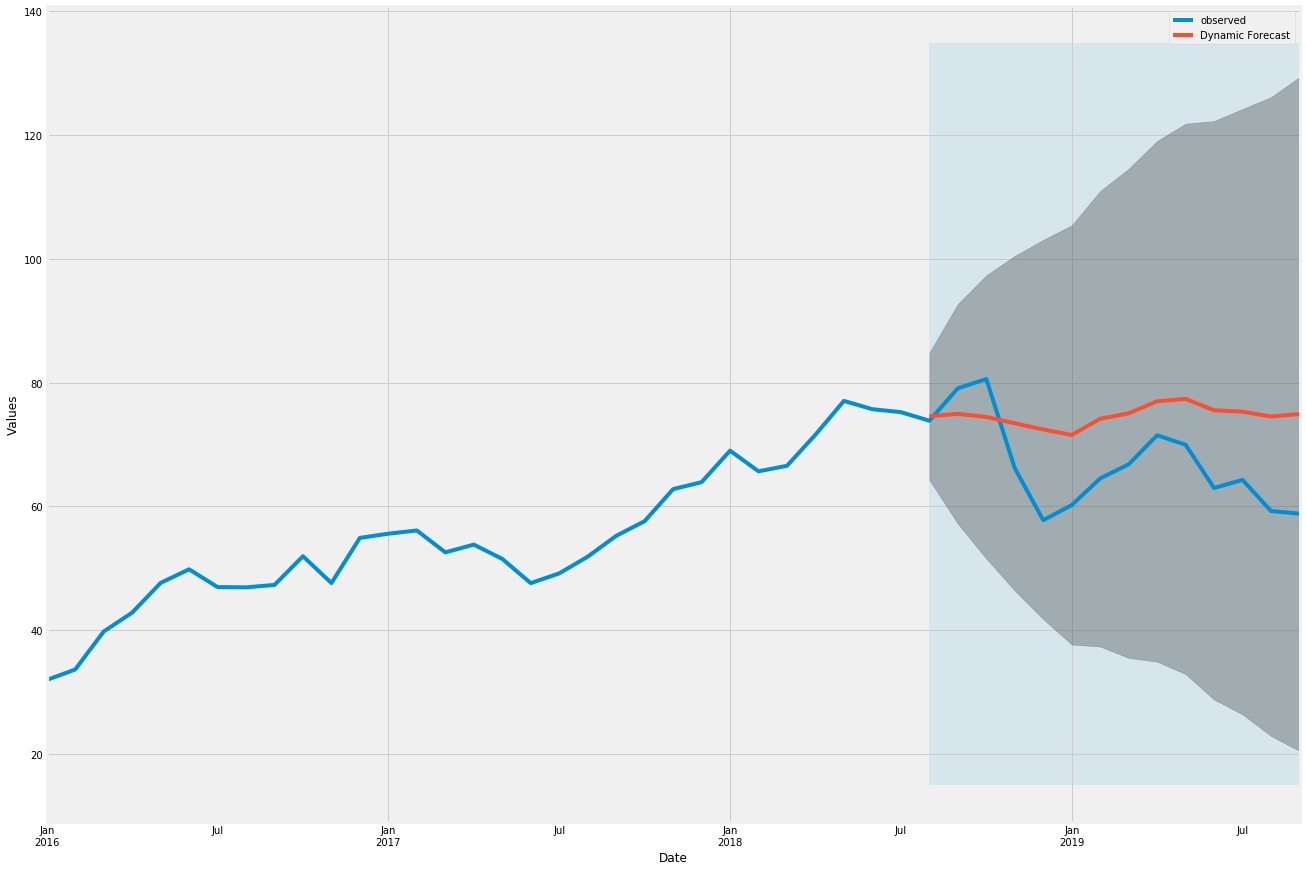

In [33]:
ax = df['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-08-01'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()
plt.show()

In [34]:
# Extract the predicted and true values of our time series
df_forecasted = pred_dynamic.predicted_mean
df_truth = df['1998-01-01':]

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 104.75


In [35]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

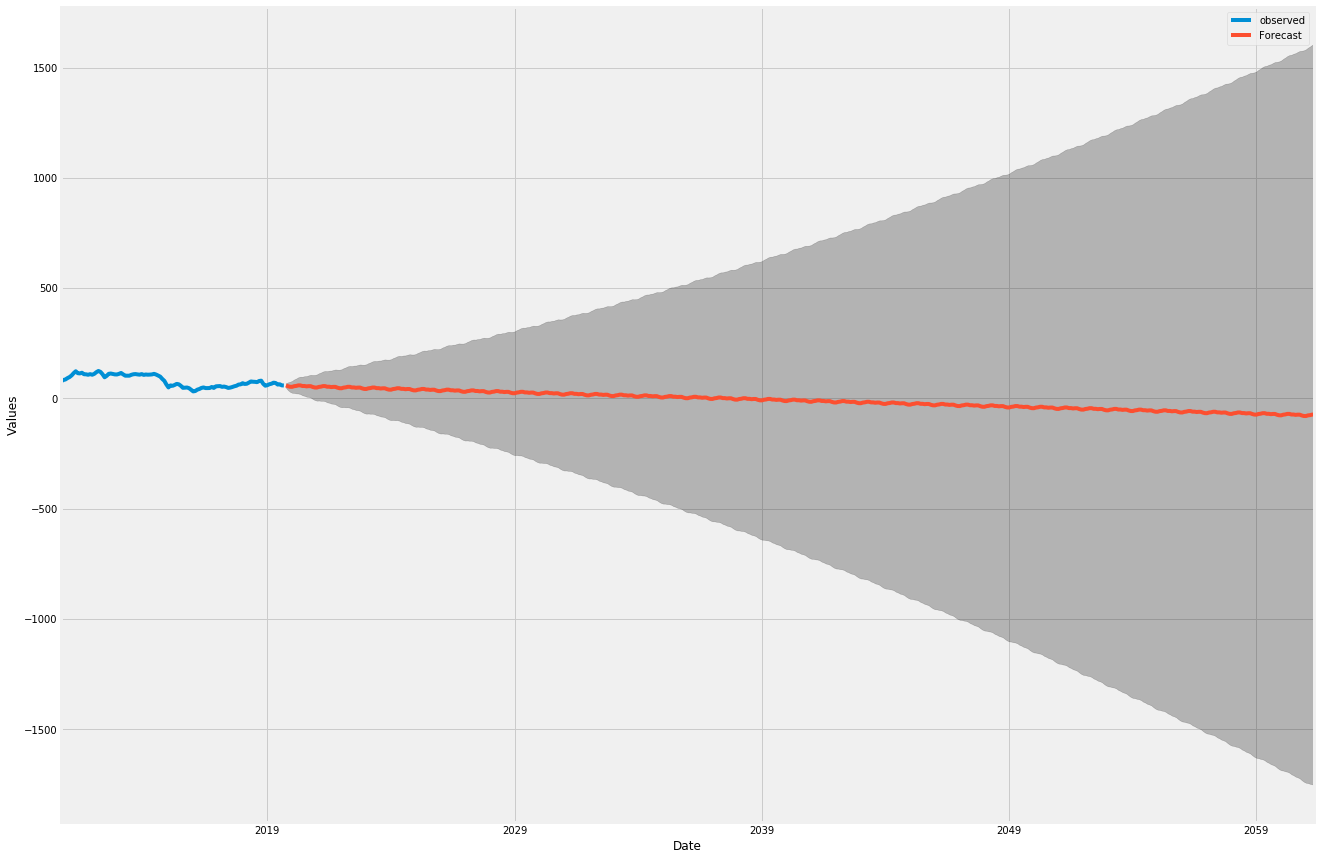

In [36]:
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()
plt.show()